In [143]:
from mads_datasets.base import BaseDatastreamer
from mltrainer.preprocessors import BasePreprocessor
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
from torch import nn
import torch

import sys

sys.path.append("../")
from src import datasets, metrics
import mltrainer

mltrainer.__version__

'0.1.128'

In [144]:
trainfile = Path("../data/heart_train.parq").resolve()
testfile = Path("../data/heart_test.parq").resolve()
# trainfile = Path('../data/heart_big_train.parq').resolve()
# testfile = Path('../data/heart_big_test.parq').resolve()

In [145]:
traindataset = datasets.HeartDataset1D(trainfile, target="target")
testdataset = datasets.HeartDataset1D(testfile, target="target")
traindataset, testdataset

# moving to mps device crashes the jypyter kernel, not sure why

(Heartdataset (len 11641), Heartdataset (len 2911))

In [146]:
trainstreamer = BaseDatastreamer(
    traindataset, preprocessor=BasePreprocessor(), batchsize=32
)
teststreamer = BaseDatastreamer(
    testdataset, preprocessor=BasePreprocessor(), batchsize=32
)
len(trainstreamer), len(teststreamer)

(363, 90)

In [147]:
class GRUBlock(nn.Module):
    def __init__(self, hidden_size, dropout):
        super(GRUBlock, self).__init__()
        self.gru = nn.GRU(
            input_size=hidden_size,
            hidden_size=hidden_size,
            batch_first=True,
        )
        self.ff = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, hidden_size),
        )
        self.layer_norm1 = nn.LayerNorm(hidden_size)
        self.layer_norm2 = nn.LayerNorm(hidden_size)

    def forward(self, x):
        identity = x.clone()  # skip connection
        x, _ = self.gru(x)
        x = self.layer_norm1(x + identity)  # Add & Norm skip

        identity = x.clone()  # second skip connection
        x = self.ff(x)
        x = self.layer_norm2(x + identity)  # Add & Norm skip
        return x


class GRUModel(nn.Module):
    def __init__(
        self,
        config: dict,
    ) -> None:
        super().__init__()
        self.conv1d = nn.Conv1d(
            in_channels=1,
            out_channels=config["hidden"],
            kernel_size=3,
            stride=2,
            padding=1,
        )

        # Create multiple GRU blocks
        self.gru_blocks = nn.ModuleList(
            [
                GRUBlock(config["hidden"], config["dropout"])
                for _ in range(config["num_blocks"])
            ]
        )

        self.out = nn.Linear(config["hidden"], config["output"])

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # streamer: (batch, seq_len, channels)
        # conv1d:   (batch, channels, seq_len)
        # gru:      (batch, seq_len, channels)
        x = self.conv1d(x.transpose(1, 2))  # flip channels and seq_len for conv1d
        x = x.transpose(1, 2)  # flip back to seq_len and channels

        # Apply multiple GRU blocks
        for gru_block in self.gru_blocks:
            x = gru_block(x)

        x = x.mean(dim=1)  # Global Average Pooling
        x = self.out(x)
        return x

In [148]:
from src import models

config = {
    "hidden": 512,
    "dropout": 0.2,
    "output": 2,
    "num_heads": 4,
    "num_blocks": 3,
}
model = models.GRUModel(config)

In [149]:
x, y = next(trainstreamer.stream())
x.shape, y.shape

(torch.Size([32, 192, 1]), torch.Size([32]))

In [150]:
yhat = model(x)
yhat.shape

torch.Size([32, 2])

In [151]:
f1micro = metrics.F1Score(average="micro")
f1macro = metrics.F1Score(average="macro")
precision = metrics.Precision("micro")
recall = metrics.Recall("macro")
accuracy = metrics.Accuracy()

In [152]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mads_exam.db")
mlflow.set_experiment("Gru")

<Experiment: artifact_location='/home/azureuser/code/mads-exam-24/notebooks/mlruns/3', creation_time=1718891292788, experiment_id='3', last_update_time=1718891292788, lifecycle_stage='active', name='Gru', tags={'mlflow.sharedViewState.5afa284720482c69cab0ae2dde87492f166b12f31ed69236707afb7478ee8c5c': '{"searchFilter":"","orderByKey":"attributes.start_time","orderByAsc":false,"startTime":"ALL","lifecycleFilter":"Active","datasetsFilter":[],"modelVersionFilter":"All '
                                                                                            'Runs","selectedColumns":["attributes.`Source`","attributes.`Models`","attributes.`Dataset`"],"runsExpanded":{},"runsPinned":[],"runsHidden":[],"runsHiddenMode":"FIRST_10_RUNS","viewMaximized":false,"runListHidden":false,"isAccordionReordered":false,"groupBy":null,"groupsExpanded":{},"autoRefreshEnabled":false}'}>

In [153]:
from mltrainer import Trainer, TrainerSettings, ReportTypes
import torch.optim as optim

loss_fn = torch.nn.CrossEntropyLoss()

optimizer = optim.Adam
# scheduler = optim.lr_scheduler.ReduceLROnPlateau

with mlflow.start_run():
    optimizer = torch.optim.Adam

    settings = TrainerSettings(
        epochs=5,
        metrics=[accuracy, f1micro, f1macro, precision, recall],
        logdir="heart1D",
        train_steps=len(trainstreamer),
        valid_steps=len(teststreamer),
        reporttypes=[ReportTypes.MLFLOW],
        scheduler_kwargs=None,
        earlystop_kwargs=None,
    )

    mlflow.set_tag("model", "Gru_Basic")
    mlflow.set_tag("dataset", "heart_small_binary")
    mlflow.log_params(config)
    mlflow.log_param("epochs", settings.epochs)
    mlflow.log_param("optimizer", str(optimizer))
    mlflow.log_param("scheduler", "None")
    mlflow.log_param("earlystop", "None")
    mlflow.log_params(settings.optimizer_kwargs)

    trainer = Trainer(
        model=model,
        settings=settings,
        loss_fn=loss_fn,
        optimizer=optimizer,
        traindataloader=trainstreamer.stream(),
        validdataloader=teststreamer.stream(),
        scheduler=None,
    )
    trainer.loop()

2024-06-30 11:23:22.817 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to heart1D/20240630-112322
100%|██████████| 363/363 [09:21<00:00,  1.55s/it]
2024-06-30 11:33:30.967 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 0.6151 test 0.5636 metric ['0.7219', '0.7219', '0.4181', '0.7219', '0.5000']
100%|██████████| 363/363 [09:20<00:00,  1.54s/it]
2024-06-30 11:43:38.446 | INFO     | mltrainer.trainer:report:191 - Epoch 1 train 0.5659 test 0.5355 metric ['0.7233', '0.7233', '0.4187', '0.7233', '0.5000']
100%|██████████| 363/363 [09:20<00:00,  1.54s/it]
2024-06-30 11:53:45.554 | INFO     | mltrainer.trainer:report:191 - Epoch 2 train 0.5740 test 0.5625 metric ['0.7229', '0.7229', '0.4183', '0.7229', '0.5000']
100%|██████████| 363/363 [09:48<00:00,  1.62s/it]
2024-06-30 12:04:20.934 | INFO     | mltrainer.trainer:report:191 - Epoch 3 train 0.5554 test 0.5195 metric ['0.7222', '0.7222', '0.4182', '0.7222', '0.5000']
100%|██████████| 363/363 [10:18<00:00,  1.70s/it]
2

[Text(0.5, 23.52222222222222, 'Predicted'),
 Text(50.722222222222214, 0.5, 'Target')]

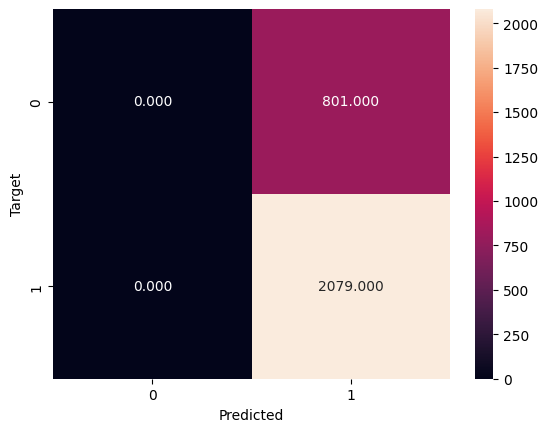

In [154]:
import seaborn as sns
import numpy as np

y_true = []
y_pred = []

testdata = teststreamer.stream()
for _ in range(len(teststreamer)):
    X, y = next(testdata)
    yhat = model(X)
    yhat = yhat.argmax(dim=1)  # we get the one with the highest probability
    y_pred.append(yhat.cpu().tolist())
    y_true.append(y.cpu().tolist())

yhat = [x for y in y_pred for x in y]
y = [x for y in y_true for x in y]

cfm = confusion_matrix(y, yhat)
# cfm = cfm / np.sum(cfm, axis=1, keepdims=True)

plot = sns.heatmap(cfm, annot=cfm, fmt=".3f")
plot.set(xlabel="Predicted", ylabel="Target")

In [155]:
# Haal de TP en FN waarden uit de confusion matrix
TP = cfm[1, 1]  # True Positives
FN = cfm[1, 0]  # False Negatives

# Bereken de Recall
recall = TP / (TP + FN)
print(f"Recall: {recall:.3f}")

Recall: 1.000
